In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
import numpy as np 
import pickle
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.signal import lfilter

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Training Data 

In [2]:
def load_data(file_no):
    path='/home/prashanth/cifar-10-batches-py/data_batch_'+str(file_no)
    fo=open(path,'rb')
    dict=pickle.load(fo,encoding='bytes')
    X=dict[b'data']
    Y=dict[b'labels']
    fo.close
    X=X.reshape((len(X),3,32,32)).transpose(0,2,3,1).astype("uint8")
    Y=np.array(Y)
    Y_hot=np.eye(no_of_classes)[Y]
    return X,Y_hot

# Load Testing Data

In [3]:
fo_tst=open('/home/prashanth/cifar-10-batches-py/test_batch','rb')
dict=pickle.load(fo_tst,encoding='bytes')
X_tst=dict[b'data']
Y_tst=dict[b'labels']
fo_tst.close
X_tst=X_tst.reshape((len(X_tst),3,32,32)).transpose(0,2,3,1).astype("uint8")
Y_tst=np.array(Y_tst)

In [4]:
X_tst.shape

(10000, 32, 32, 3)

In [5]:
def forward_conv(height,width,inshape,outshape,input):
    weights=tf.Variable(rng.randn(height,width,inshape,outshape), dtype = tf.float32,name='conv_weights') #constant
    return(tf.nn.conv2d(input,weights,strides=[1,1,1,1],padding="SAME"))

def forward_max_pooling_layer(inp,window_size):
    return(tf.nn.max_pool(value=inp,ksize=[1,window_size,window_size,1],strides=[1,1,1,1],padding="SAME"))

def forward_avg_pooling_layer(inp,window_size):
    return(tf.nn.avg_pool(value=inp,ksize=[1,window_size,window_size,1],strides=[1,1,1,1],padding="SAME"))

def flatten_forward(layer):
    inp_list=layer.get_shape().as_list()
    new_size = inp_list[-1] * inp_list[-2] * inp_list[-3]
    return tf.reshape(layer,[-1,new_size]),new_size

def fc_forward(layer,new_size,no_of_classes):
    weights=tf.Variable(rng.randn(new_size,no_of_classes),dtype=tf.float32,name='fc_forward_weights') #constant
    return tf.matmul(layer,weights)

def fc_fc(rows,columns,layers):
    weights=tf.Variable(rng.randn(rows,columns),dtype=tf.float32,name='fc_fc_weights')
    return tf.matmul(layers,weights)

def activation(layer):
    return tf.nn.relu(layer)

In [6]:
@tf.RegisterGradient("CustomConv")
def _conv2d(op,grad):
    print("in override backprop")
    input = op.inputs[0]
    filter = op.inputs[1]
    in_shape = tf.shape(input)
    f_shape = tf.shape(filter)
    g_input = tf.nn.conv2d_backprop_input(input_sizes = in_shape, filter = filter, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    g_filter = tf.nn.conv2d_backprop_filter(input, filter_sizes = f_shape, out_backprop = grad, strides = [1,1,1,1], padding = "SAME")
    return g_input, g_filter

In [7]:
#PARAMETERS
num_epochs=65
batch=1000
iterations=1000
no_of_classes=10

Y_hot_tst=np.eye(no_of_classes)[Y_tst]


images=tf.placeholder(tf.float32,shape=(None,32,32,3),name='images')
true_labels=tf.placeholder(tf.float32,shape=(None,10),name='true_labels')

# Random FeedBack

In [8]:
#LAYER1
filter_random1 = tf.Variable(rng.randn(5,5,3,32), dtype = tf.float32,name='random_filter1')

g=tf.get_default_graph()
with g.gradient_override_map({"Conv2D": "CustomConv"}):
    net_conv=tf.nn.conv2d(images,filter_random1,strides=[1,1,1,1],padding="SAME")

net_pool= forward_max_pooling_layer(net_conv,3)
net_act=activation(net_pool)

#LAYER 2
filter_random2 = tf.Variable(rng.randn(5,5,32,64), dtype = tf.float32,name='random_filter2')
with g.gradient_override_map({"Conv2D":"CustomConv"}):
    net_conv2=tf.nn.conv2d(net_act,filter_random2,strides=[1,1,1,1],padding="SAME")
net_pool2= forward_avg_pooling_layer(net_conv2,3)
net_act2=activation(net_pool2)


#LAYER 3
filter_random3=tf.Variable(rng.randn(5,5,64,64),dtype=tf.float32,name='random_filter3')
with g.gradient_override_map({"Conv2D":"CustomConv"}):
    net_conv3=tf.nn.conv2d(net_act2,filter_random3,strides=[1,1,1,1],padding="SAME")
net_pool3=forward_avg_pooling_layer(net_conv3,3)

net_act3=activation(net_pool3)

net_flatten,new_size=flatten_forward(net_act3)

net_fc=fc_forward(net_flatten,new_size,128)
net_act4=activation(net_fc)
output=fc_fc(128,no_of_classes,net_act4)

#compute loss

cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=
                                  output,labels=true_labels)
cost = tf.reduce_mean(cross_entropy)

# Back Prop

In [9]:
# filter_conv_bp=tf.Variable(rng.randn(5,5,3,16), dtype = tf.float32)

#LAYER 1
net_conv_bp= forward_conv(5,5,3,32,images) # height,width,inshape,outshape
net_pool_bp = forward_max_pooling_layer(net_conv_bp,3) #output,windowsize
net_act_bp=activation(net_pool_bp)

#LAYER 2
net_conv_bp2 = forward_conv(5,5,32,64,net_act_bp) # height,width,inshape,outshape
net_pool_bp2 = forward_avg_pooling_layer(net_conv_bp2,3) #output,windowsize
net_act_bp2=activation(net_pool_bp2)

#LAYER 3
net_conv_bp3=forward_conv(5,5,64,64,net_act_bp2)
net_pool_bp3=forward_avg_pooling_layer(net_conv_bp3,3)
net_act_bp3=activation(net_pool_bp3)

net_flatten_bp,new_size_bp=flatten_forward(net_act_bp3)
net_fc_bp1=fc_forward(net_flatten_bp,new_size_bp,128)
net_act_bp4=activation(net_fc_bp1)
output_bp=fc_fc(128,no_of_classes,net_act_bp4)


#cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits_v2(logits=
#                                  output_bp,labels=true_labels)
cross_entropy_bp=tf.nn.softmax_cross_entropy_with_logits(logits=
                                  output_bp,labels=true_labels)
cost_bp=tf.reduce_mean(cross_entropy_bp)

In [10]:
accuracy_fa=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1),tf.argmax(true_labels,1)),tf.float32))
accuracy_bp=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_bp,1),tf.argmax(true_labels,1)),tf.float32))

In [11]:
#BP gradients
bp_grad = tf.gradients(cross_entropy_bp, images)

override_grad = tf.gradients(cross_entropy, images)

in override backprop
in override backprop
in override backprop


In [20]:
train_op_bp = tf.train.MomentumOptimizer(learning_rate=0.0000001,momentum=0.9).minimize(cost_bp)
train_op_fa=tf.train.MomentumOptimizer(learning_rate=0.0000001,momentum=0.9).minimize(cost)

in override backprop
in override backprop
in override backprop


In [ ]:
store_err_bp=[]
store_err_fa=[]
acc_fa=[]
acc_bp=[]
testing_fa=[]
testing_bp=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        print("\n\t\t\tEPOCH NO:",epoch+1)
        no=np.random.randint(1,5)
        X,Y_hot=load_data(no)
        print("Picking from data batch:",no)
        batch_no=np.random.randint(0,X.shape[0],size=batch)
        
        for count in range(iterations):
            inp_features=X[batch_no,:,:,:]
            inp_features=inp_features.astype(np.float32)

            inp_labels=Y_hot[batch_no,:]
            inp_labels=inp_labels.astype(np.float32)

#             autobp_input=sess.run(bp_grad,feed_dict={images:inp_features,true_labels:inp_labels})
#             override_input=sess.run(override_grad,feed_dict={images:inp_features,true_labels:inp_labels})

            sess.run(train_op_bp,feed_dict={images:inp_features,true_labels:inp_labels})
            sess.run(train_op_fa,feed_dict={images:inp_features,true_labels:inp_labels})

            entropy_bp=sess.run(cross_entropy_bp,feed_dict={images:inp_features,true_labels:inp_labels})
            store_err_bp.append(np.mean(entropy_bp))
            entropy_fa=sess.run(cross_entropy,feed_dict={images:inp_features,true_labels:inp_labels})
            store_err_fa.append(np.mean(entropy_fa))

            acc_fa.append(sess.run(accuracy_fa,feed_dict={images:inp_features,true_labels:inp_labels}))
            acc_bp.append(sess.run(accuracy_bp,feed_dict={images:inp_features,true_labels:inp_labels}))


            if (count+1)%200==0:
                print("Iteration:",count+1)
                print("BackPropagation:",sess.run(cost_bp,feed_dict={images:inp_features,true_labels:inp_labels}),
                      "\t Feedback:",sess.run(cost,feed_dict={images:inp_features,true_labels:inp_labels}))
                
                
        #Resource Exhausted with loading the entire testing data which has 10000 images.
        #Instead testing on 1000 random images selected from the testing data. results may not be as consistent
        
        pick_rnd=np.random.randint(0,X_tst.shape[0],1000)
        tst_fa=sess.run(accuracy_fa,feed_dict={images:X_tst[pick_rnd,:,:,:].astype(np.float32),
                                               true_labels:Y_hot_tst[pick_rnd,:]})
        tst_bp=sess.run(accuracy_bp,feed_dict={images:X_tst[pick_rnd,:,:,:].astype(np.float32),
                                               true_labels:Y_hot_tst[pick_rnd,:]})

        testing_fa.append(tst_fa)
        testing_bp.append(tst_bp)
        
        print("\nAt the end of EPOCH:",epoch+1)
        print("Testing Accuracy:\nBack Propagation",tst_bp,"\tRandom Feedback:",tst_fa)


			EPOCH NO: 1
Picking from data batch: 3
Iteration: 200
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 400
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 600
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 800
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 1000
BackPropagation: nan 	 Feedback: 2.3025851

At the end of EPOCH: 1
Testing Accuracy:
Back Propagation 0.105 	Random Feedback: 0.105

			EPOCH NO: 2
Picking from data batch: 1
Iteration: 200
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 400
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 600
BackPropagation: nan 	 Feedback: 2.3025851
Iteration: 800
BackPropagation: nan 	 Feedback: 2.3025851


In [ ]:
plt.plot(acc_fa)
plt.plot(acc_bp)
plt.show()

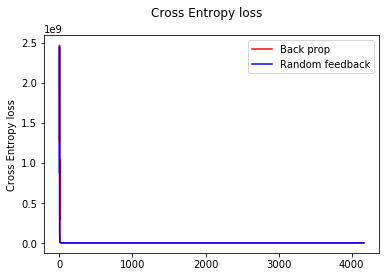

In [14]:
plt.plot(store_err_bp,'r',label='Back prop')
plt.plot(store_err_fa,'b',label='Random feedback')
plt.suptitle('Cross Entropy loss')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

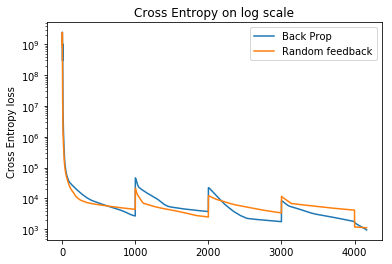

In [15]:
plt.semilogy(store_err_bp,label='Back Prop')
plt.semilogy(store_err_fa,label='Random feedback')
plt.title('Cross Entropy on log scale')
plt.ylabel('Cross Entropy loss')
plt.legend()
plt.show()

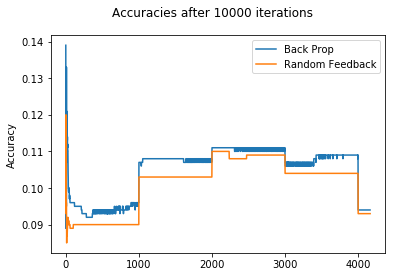

In [16]:
plt.plot(acc_bp,label='Back Prop')
plt.plot(acc_fa,label='Random Feedback')
plt.ylabel('Accuracy')
plt.suptitle("Accuracies after 10000 iterations")
plt.legend()
plt.show()

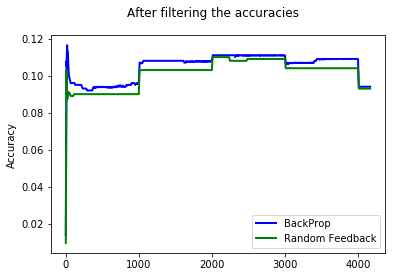

In [17]:
n = 10 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy_bp = lfilter(b,a,acc_bp)
yy_fa = lfilter(b,a,acc_fa)

plt.plot( yy_bp, linewidth=2, linestyle="-", c="b",label='BackProp')

plt.plot( yy_fa, linewidth=2, linestyle="-", c="g",label='Random Feedback')
plt.suptitle('After filtering the accuracies')
plt.legend()
plt.ylabel('Accuracy')
plt.show()